In [7]:
#### ---------------------------------------------------------------------------------------------------------------------------
#### author: Ranjan Barman, date: July 11, 2025
#### predict individual BRCA Subtype Status using All HoverNet predicted NNPIFs and also save the models for external validation
#### ----------------------------------------------------------------------------------------------------------------------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from collections import Counter, defaultdict
from sklearn.model_selection import cross_val_predict, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, f1_score, roc_auc_score, roc_curve, auc
import random
import joblib

_wpath_ = "/data/Lab_ruppin/Ranjan/HnE/"
os.chdir(_wpath_)

print(f"working directory = {_wpath_}\n")



working directory = /data/Lab_ruppin/Ranjan/HnE/



In [8]:
# Define dataset and file paths
dataset_name = "PA_PIF_BRCA"
outcome_names = ["HER2_Status", "PR_Status", "ER_Status"]

# File paths
PathAI_PIFs_with_BRCA_status_file = f"{dataset_name}/outputs_biomarker_status/tcga_brca_subtype_to_original_pifs.csv"

# Output path to save results and plots
out_path = f"{dataset_name}/outputs/Prediction_results_PathAI_NPIFs_Binary_Subtypes/"
model_save_path = os.path.join(out_path, "saved_models/")
os.makedirs(model_save_path, exist_ok=True) # Creates directory if it doesn't exist already

# read files 
PathAI_PIFs_with_BRCA_status_full = pd.read_csv(PathAI_PIFs_with_BRCA_status_file)

# Remove trailing spaces from column names
PathAI_PIFs_with_BRCA_status_full.columns = PathAI_PIFs_with_BRCA_status_full.columns.str.strip()


# The number of samples used for TCGA BRCA subtype prediction 
TCGA_BRCA_Subtypes_556_file = "TCGA_BRCA_FFPE/outputs/HoverNet/Subtypes/outputs_biomarker_status_prediction_results_All_HoverNet_NPIFs/combined_class_predictions_all_features_for_subtypes.csv"

TCGA_BRCA_Subtypes_556 = pd.read_csv(TCGA_BRCA_Subtypes_556_file)

# Convert the first column ("sample") to a series
sample_list_556 = TCGA_BRCA_Subtypes_556['sample_id'].reset_index(drop=True)

# Filter sample based on `sample_list_556`
PathAI_PIFs_with_BRCA_status_full = PathAI_PIFs_with_BRCA_status_full[PathAI_PIFs_with_BRCA_status_full['sample_id'].isin(sample_list_556)].copy()

# Convert the first column ("sample") to a series
patient_list = PathAI_PIFs_with_BRCA_status_full['sample_id'].reset_index(drop=True)

# Define list of selected nuclear feature columns to retain
selected_features = [
    'MEAN[CANCER_NUCLEUS_AREA]_H & E',
    'MEAN[CANCER_NUCLEUS_MAJOR_AXIS_LENGTH]_H & E',
    'MEAN[CANCER_NUCLEUS_MINOR_AXIS_LENGTH]_H & E',
    'MEAN[CANCER_NUCLEUS_PERIMETER]_H & E',
    'MEAN[CANCER_NUCLEUS_CIRCULARITY]_H & E',
    'MEAN[CANCER_NUCLEUS_ECCENTRICITY]_H & E',
    'STD[CANCER_NUCLEUS_AREA]_H & E',
    'STD[CANCER_NUCLEUS_MAJOR_AXIS_LENGTH]_H & E',
    'STD[CANCER_NUCLEUS_MINOR_AXIS_LENGTH]_H & E',
    'STD[CANCER_NUCLEUS_PERIMETER]_H & E',
    'STD[CANCER_NUCLEUS_CIRCULARITY]_H & E',
    'STD[CANCER_NUCLEUS_ECCENTRICITY]_H & E'
]

# Optional: Add sample_id and subtype columns to keep
meta_columns = ['sample_id', 'HER2_Status', 'PR_Status', 'ER_Status']

# Filter merged_df to keep only the selected columns
PathAI_NPIFs_with_BRCA_status_full = PathAI_PIFs_with_BRCA_status_full[meta_columns + selected_features]


# Filter to include only rows where outcome is "Positive" or "Negative"
data_filtered = PathAI_NPIFs_with_BRCA_status_full[
    PathAI_NPIFs_with_BRCA_status_full[outcome_names].isin(["Positive", "Negative"]).all(axis=1)
]


# Filter out the patient list
filtered_patient_list = data_filtered['sample_id'].reset_index(drop=True)

# Define features (before normalization)
X = data_filtered.iloc[:, 4:].copy()


PathAI_NPIFs_with_BRCA_status_full
filtered_patient_list
data_filtered
X

,MEAN[CANCER_NUCLEUS_AREA]_H & E,MEAN[CANCER_NUCLEUS_MAJOR_AXIS_LENGTH]_H & E,MEAN[CANCER_NUCLEUS_MINOR_AXIS_LENGTH]_H & E,MEAN[CANCER_NUCLEUS_PERIMETER]_H & E,MEAN[CANCER_NUCLEUS_CIRCULARITY]_H & E,MEAN[CANCER_NUCLEUS_ECCENTRICITY]_H & E,STD[CANCER_NUCLEUS_AREA]_H & E,STD[CANCER_NUCLEUS_MAJOR_AXIS_LENGTH]_H & E,STD[CANCER_NUCLEUS_MINOR_AXIS_LENGTH]_H & E,STD[CANCER_NUCLEUS_PERIMETER]_H & E,STD[CANCER_NUCLEUS_CIRCULARITY]_H & E,STD[CANCER_NUCLEUS_ECCENTRICITY]_H & E
0,36.561916,8.579009,5.781790,23.836950,0.789023,0.697108,13.636161,1.818365,1.183849,4.639847,0.078414,0.144138
1,42.765987,9.012733,6.361746,25.581022,0.795899,0.660698,17.899511,2.139609,1.394998,5.602351,0.082863,0.153385
2,45.249550,9.253537,6.567734,26.291719,0.801859,0.661877,17.162100,2.009781,1.296982,5.249077,0.074514,0.145978
3,47.735512,9.827610,6.466487,27.548254,0.760771,0.709445,23.245815,2.580491,1.660726,7.043053,0.097753,0.145288
4,46.371204,9.408572,6.615330,26.852484,0.788655,0.663869,18.798985,2.238503,1.335307,5.820804,0.086755,0.149138
...,...,...,...,...,...,...,...,...,...,...,...,...
572,45.677532,9.100985,6.613077,26.061266,0.804127,0.643324,20.923508,2.112172,1.731736,6.032002,0.074931,0.159266
573,45.869053,9.275162,6.557035,26.689734,0.777331,0.662018,21.983963,2.377420,1.646239,6.755987,0.093805,0.152676
574,58.831284,10.317983,7.521458,29.459068,0.822693,0.643314,21.901209,2.123916,1.602507,5.651273,0.066202,0.150151
575,52.917530,9.815355,7.153934,28.218414,0.807872,0.642525,20.829773,2.100521,1.536091,5.672518,0.075902,0.150182


In [9]:
# Initialize a DataFrame to store the combined results
combined_results_df = pd.DataFrame({'sample_id': filtered_patient_list.values})
combined_results_df.set_index('sample_id', inplace=True)

# Define hyperparameter grid for Logistic Regression with L2 penalty (Ridge)
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
}

# Define cross-validation parameters
n_folds = 5
seed = 20852
shuffle = True

# Define subtype names
subtype_names_3 = ['HER2_Positive', 'HR_Positive', 'TNBC_3']
subtype_names_4 = ['HR+', 'TNBC_4', 'TPBC', 'HER2+']
all_subtype_names = subtype_names_3 + subtype_names_4

# Step 1: Define true subtypes from HER2/ER/PR status
def define_true_subtypes(df):
    HER2 = df['HER2_Status'] == 'Positive'
    ER = df['ER_Status'] == 'Positive'
    PR = df['PR_Status'] == 'Positive'

    df['HER2_Positive'] = HER2.astype(int)
    df['HR_Positive'] = ((ER | PR) & ~HER2).astype(int)
    df['TNBC_3'] = (~HER2 & ~ER & ~PR).astype(int)

    df['HR+'] = (ER & ~HER2).astype(int)
    df['TNBC_4'] = (~ER & ~HER2).astype(int)
    df['TPBC'] = (ER & HER2).astype(int)
    df['HER2+'] = (~ER & HER2).astype(int)

    return df

# Apply subtype definition
data_filtered = define_true_subtypes(data_filtered)

# Step 2: Define NPIF features only (exclude all label-related columns)
columns_to_exclude = ['sample_id', 'HER2_Status', 'PR_Status', 'ER_Status',
                      'HER2_Positive', 'HR_Positive', 'TNBC_3', 'HR+',
                      'TNBC_4', 'TPBC', 'HER2+']
feature_columns = [col for col in data_filtered.columns if col not in columns_to_exclude]
X = data_filtered[feature_columns].copy()

data_filtered
# feature_columns
X

,MEAN[CANCER_NUCLEUS_AREA]_H & E,MEAN[CANCER_NUCLEUS_MAJOR_AXIS_LENGTH]_H & E,MEAN[CANCER_NUCLEUS_MINOR_AXIS_LENGTH]_H & E,MEAN[CANCER_NUCLEUS_PERIMETER]_H & E,MEAN[CANCER_NUCLEUS_CIRCULARITY]_H & E,MEAN[CANCER_NUCLEUS_ECCENTRICITY]_H & E,STD[CANCER_NUCLEUS_AREA]_H & E,STD[CANCER_NUCLEUS_MAJOR_AXIS_LENGTH]_H & E,STD[CANCER_NUCLEUS_MINOR_AXIS_LENGTH]_H & E,STD[CANCER_NUCLEUS_PERIMETER]_H & E,STD[CANCER_NUCLEUS_CIRCULARITY]_H & E,STD[CANCER_NUCLEUS_ECCENTRICITY]_H & E
0,36.561916,8.579009,5.781790,23.836950,0.789023,0.697108,13.636161,1.818365,1.183849,4.639847,0.078414,0.144138
1,42.765987,9.012733,6.361746,25.581022,0.795899,0.660698,17.899511,2.139609,1.394998,5.602351,0.082863,0.153385
2,45.249550,9.253537,6.567734,26.291719,0.801859,0.661877,17.162100,2.009781,1.296982,5.249077,0.074514,0.145978
3,47.735512,9.827610,6.466487,27.548254,0.760771,0.709445,23.245815,2.580491,1.660726,7.043053,0.097753,0.145288
4,46.371204,9.408572,6.615330,26.852484,0.788655,0.663869,18.798985,2.238503,1.335307,5.820804,0.086755,0.149138
...,...,...,...,...,...,...,...,...,...,...,...,...
572,45.677532,9.100985,6.613077,26.061266,0.804127,0.643324,20.923508,2.112172,1.731736,6.032002,0.074931,0.159266
573,45.869053,9.275162,6.557035,26.689734,0.777331,0.662018,21.983963,2.377420,1.646239,6.755987,0.093805,0.152676
574,58.831284,10.317983,7.521458,29.459068,0.822693,0.643314,21.901209,2.123916,1.602507,5.651273,0.066202,0.150151
575,52.917530,9.815355,7.153934,28.218414,0.807872,0.642525,20.829773,2.100521,1.536091,5.672518,0.075902,0.150182


In [10]:
# Initialize result storage
results = {}
mean_f1_scores = []

# Loop through each subtype
for subtype in all_subtype_names:
    print(f"\nProcessing subtype: {subtype}")
    
    y = data_filtered[subtype]
    y_encoded = y.copy()

    outer_results = []
    y_true_all_folds = []
    predictions = []
    f1_scores = []

    # Track coefficients for all features across folds
    all_features = X.columns.tolist()
    coeff_tracker = {feat: [] for feat in all_features}  # values per fold, zero if not selected

    outer_cv = StratifiedKFold(n_splits=n_folds, shuffle=shuffle, random_state=seed)
    fold_idx = 1

    for train_idx, test_idx in outer_cv.split(X, y_encoded):
        print(f"\nOuter Fold {fold_idx}/{n_folds}")
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_encoded.iloc[train_idx], y_encoded.iloc[test_idx]
        patient_test_ids = filtered_patient_list.iloc[test_idx]

        # Print class balance
        print("Train class dist:", y_train.value_counts().to_dict())
        print("Test class dist :", y_test.value_counts().to_dict())

        inner_cv = StratifiedKFold(n_splits=n_folds, shuffle=shuffle, random_state=seed)
        
        pipeline = Pipeline([
            ('scaler', MinMaxScaler()),
            ('classifier', LogisticRegression(penalty='l1', solver='saga',
                                              class_weight='balanced', max_iter=10000))
        ])
        
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            cv=inner_cv,
            scoring='roc_auc',
            n_jobs=-1
        )
        
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print(f"Best parameters: {best_params}")
        
        # Save model
        model_filename = os.path.join(model_save_path, f"{subtype}_model_fold_{fold_idx}.joblib")
        joblib.dump(best_model, model_filename)
        print(f"Saved model with scaler: {model_filename}")

        # Extract coefficients
        coef = best_model.named_steps['classifier'].coef_.flatten()
        for feat, c in zip(all_features, coef):
            coeff_tracker[feat].append(c)  # may be zero

        # Predict
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        predictions.append(y_pred_proba)
        y_true_all_folds.extend(y_test)

        # Save predictions to results DataFrame
        combined_results_df.loc[patient_test_ids.values, f'true_label_{subtype}'] = y_test.values
        combined_results_df.loc[patient_test_ids.values, f'predicted_probability_{subtype}'] = y_pred_proba

        # Evaluate
        f1 = f1_score(y_test, (y_pred_proba >= 0.5).astype(int))
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        f1_scores.append(f1)

        print(f"F1-score: {f1:.4f}")
        print(f"ROC AUC : {roc_auc:.4f}")

        outer_results.append({
            'fold': fold_idx,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'best_params': best_params
        })

        fold_idx += 1

    # Save results
    mean_f1_score = np.mean(f1_scores)
    print(f"Mean F1-score for {subtype}: {mean_f1_score:.4f}")

    results[subtype] = {
        'outer_results': outer_results,
        'mean_f1_score': mean_f1_score,
        'best_params': best_params
    }
    mean_f1_scores.append(mean_f1_score)

    # Fill missing folds with 0s
    for feat in coeff_tracker:
        if len(coeff_tracker[feat]) < n_folds:
            coeff_tracker[feat] += [0.0] * (n_folds - len(coeff_tracker[feat]))
    
    # Convert to DataFrame with fold-wise rows and features as columns
    fold_coefficients_df = pd.DataFrame(coeff_tracker)
    fold_coefficients_df.index.name = 'fold'
    fold_coefficients_df.index = [f'Fold_{i+1}' for i in range(n_folds)]
    
    # Save all coefficients (including zeros) fold-wise
    coeff_output_file = os.path.join(out_path, f"{subtype}_foldwise_coefficients.csv")
    fold_coefficients_df.to_csv(coeff_output_file)
    print(f"Saved fold-wise coefficients (including zeros) for {subtype} to: {coeff_output_file}")



Processing subtype: HER2_Positive

Outer Fold 1/5
Train class dist: {0: 378, 1: 66}
Test class dist : {0: 95, 1: 17}
Best parameters: {'classifier__C': 100}
Saved model with scaler: PA_PIF_BRCA/outputs/Prediction_results_PathAI_NPIFs_Binary_Subtypes/saved_models/HER2_Positive_model_fold_1.joblib
F1-score: 0.3934
ROC AUC : 0.8285

Outer Fold 2/5
Train class dist: {0: 378, 1: 67}
Test class dist : {0: 95, 1: 16}
Best parameters: {'classifier__C': 10}
Saved model with scaler: PA_PIF_BRCA/outputs/Prediction_results_PathAI_NPIFs_Binary_Subtypes/saved_models/HER2_Positive_model_fold_2.joblib
F1-score: 0.3860
ROC AUC : 0.7842

Outer Fold 3/5
Train class dist: {0: 378, 1: 67}
Test class dist : {0: 95, 1: 16}
Best parameters: {'classifier__C': 100}
Saved model with scaler: PA_PIF_BRCA/outputs/Prediction_results_PathAI_NPIFs_Binary_Subtypes/saved_models/HER2_Positive_model_fold_3.joblib
F1-score: 0.3600
ROC AUC : 0.7276

Outer Fold 4/5
Train class dist: {0: 379, 1: 66}
Test class dist : {0: 94,

/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/Anaconda/

Best parameters: {'classifier__C': 100}
Saved model with scaler: PA_PIF_BRCA/outputs/Prediction_results_PathAI_NPIFs_Binary_Subtypes/saved_models/HER2+_model_fold_1.joblib
F1-score: 0.0909
ROC AUC : 0.6897

Outer Fold 2/5
Train class dist: {0: 425, 1: 20}
Test class dist : {0: 106, 1: 5}


/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/Anaconda/

Best parameters: {'classifier__C': 100}
Saved model with scaler: PA_PIF_BRCA/outputs/Prediction_results_PathAI_NPIFs_Binary_Subtypes/saved_models/HER2+_model_fold_2.joblib
F1-score: 0.1935
ROC AUC : 0.7981

Outer Fold 3/5
Train class dist: {0: 425, 1: 20}
Test class dist : {0: 106, 1: 5}


/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/Anaconda/

Best parameters: {'classifier__C': 100}
Saved model with scaler: PA_PIF_BRCA/outputs/Prediction_results_PathAI_NPIFs_Binary_Subtypes/saved_models/HER2+_model_fold_3.joblib
F1-score: 0.2000
ROC AUC : 0.7717

Outer Fold 4/5
Train class dist: {0: 425, 1: 20}
Test class dist : {0: 106, 1: 5}


/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/Anaconda/

Best parameters: {'classifier__C': 100}
Saved model with scaler: PA_PIF_BRCA/outputs/Prediction_results_PathAI_NPIFs_Binary_Subtypes/saved_models/HER2+_model_fold_4.joblib
F1-score: 0.1818
ROC AUC : 0.8208

Outer Fold 5/5
Train class dist: {0: 425, 1: 20}
Test class dist : {0: 106, 1: 5}


/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/Anaconda/

Best parameters: {'classifier__C': 100}
Saved model with scaler: PA_PIF_BRCA/outputs/Prediction_results_PathAI_NPIFs_Binary_Subtypes/saved_models/HER2+_model_fold_5.joblib
F1-score: 0.1429
ROC AUC : 0.6283
Mean F1-score for HER2+: 0.1618
Saved fold-wise coefficients (including zeros) for HER2+ to: PA_PIF_BRCA/outputs/Prediction_results_PathAI_NPIFs_Binary_Subtypes/HER2+_foldwise_coefficients.csv


/usr/local/Anaconda/envs/py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [11]:
# Save combined prediction outputs
combined_results_df.to_csv(os.path.join(out_path, 'combined_class_predictions_all_subtypes_binary.csv'), index=True)
combined_results_df

,true_label_HER2_Positive,predicted_probability_HER2_Positive,true_label_HR_Positive,predicted_probability_HR_Positive,true_label_TNBC_3,predicted_probability_TNBC_3,true_label_HR+,predicted_probability_HR+,true_label_TNBC_4,predicted_probability_TNBC_4,true_label_TPBC,predicted_probability_TPBC,true_label_HER2+,predicted_probability_HER2+
sample_id,,,,,,,,,,,,,,
TCGA-A1-A0SB,0.0,0.164752,1.0,0.852139,0.0,0.180526,1.0,0.832614,0.0,0.244520,0.0,0.251625,0.0,0.000537
TCGA-A1-A0SD,0.0,0.148401,1.0,0.866093,0.0,0.159163,1.0,0.819305,0.0,0.256426,0.0,0.228149,0.0,0.003385
TCGA-A1-A0SE,0.0,0.138932,1.0,0.832816,0.0,0.360629,1.0,0.836971,0.0,0.306502,0.0,0.262882,0.0,0.000200
TCGA-A1-A0SF,0.0,0.199050,1.0,0.503453,0.0,0.522115,1.0,0.689894,0.0,0.722671,0.0,0.326927,0.0,0.000039
TCGA-A1-A0SH,0.0,0.064638,1.0,0.963318,0.0,0.072725,0.0,0.952991,1.0,0.119640,0.0,0.150876,0.0,0.000013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-EW-A1PB,0.0,0.588328,0.0,0.161446,1.0,0.617210,0.0,0.158536,1.0,0.558337,0.0,0.365416,0.0,0.947898
TCGA-EW-A1PD,1.0,0.057830,0.0,0.923161,0.0,0.518143,0.0,0.749533,0.0,0.450373,1.0,0.145840,0.0,0.000001
TCGA-EW-A1PE,0.0,0.327256,1.0,0.712327,0.0,0.479669,1.0,0.689299,0.0,0.476425,0.0,0.477829,0.0,0.002101


In [12]:
# Mapping for 3-subtype ROC plotting
subtypes_3 = {
    'HER2_Positive': ('true_label_HER2_Positive', 'predicted_probability_HER2_Positive'),
    'HR_Positive': ('true_label_HR_Positive', 'predicted_probability_HR_Positive'),
    'TNBC_3': ('true_label_TNBC_3', 'predicted_probability_TNBC_3')
}

# Mapping for 4-subtype ROC plotting
subtypes_4 = {
    'HR+': ('true_label_HR+', 'predicted_probability_HR+'),
    'TNBC_4': ('true_label_TNBC_4', 'predicted_probability_TNBC_4'),
    'TPBC': ('true_label_TPBC', 'predicted_probability_TPBC'),
    'HER2+': ('true_label_HER2+', 'predicted_probability_HER2+')
}


In [13]:
colors = {
    'HER2_Positive': 'darkorange',
    'HR_Positive': 'blue',
    'TNBC_3': 'green',
    'HR+': 'blue',
    'TNBC_4': 'green',
    'TPBC': 'tomato',
    'HER2+': 'darkorange'
}
def plot_combined_roc_curves(df, subtypes, title, filename):
    plt.figure(figsize=(10, 8))
    total_samples = len(df)

    for subtype, (true_label_col, pred_prob_col) in subtypes.items():
        if subtype in ['TNBC_3', 'TNBC_4']:
            if 'TNBC' in colors:  # Avoid duplicated legend for TNBC
                continue
            label = 'TNBC'
        elif subtype == 'HER2_Positive':
            label = 'HER2+'
        elif subtype == 'HR_Positive':
            label = 'HR+'
        else:
            label = subtype

        # Filter valid entries
        valid_indices = (~df[true_label_col].isna()) & (~df[pred_prob_col].isna())
        true_labels = df[true_label_col][valid_indices]
        predicted_probs = df[pred_prob_col][valid_indices]

        # Compute ROC and AUC
        fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
        roc_auc = auc(fpr, tpr)

        # Plot
        plt.plot(fpr, tpr, color=colors[subtype], lw=2,
                 label=f'{label} (AUC = {roc_auc:.2f}, n = {true_labels.sum():.0f})')

    # Reference diagonal
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title(title, fontsize=18)
    plt.legend(loc="lower right", fontsize=18)
    plt.grid(True)

    # Save and show
    plt.savefig(os.path.join(out_path, filename), bbox_inches='tight')
    plt.show()


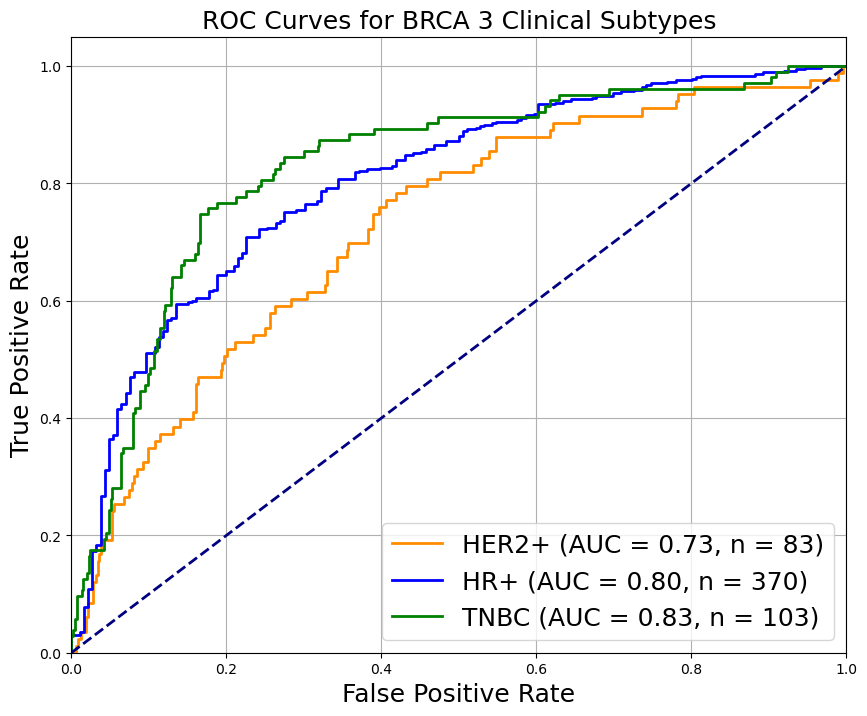

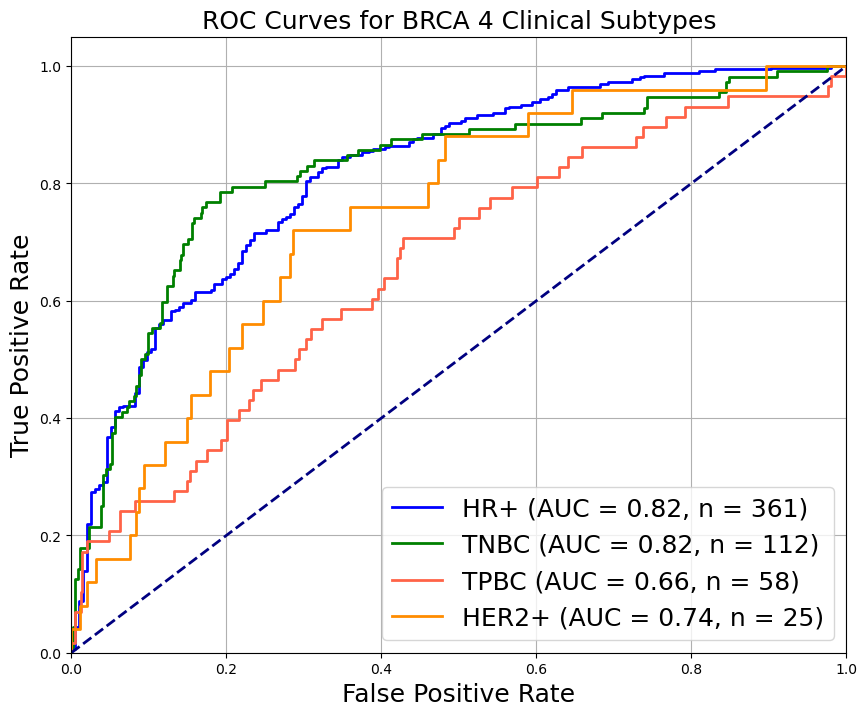

In [14]:
plot_combined_roc_curves(
    combined_results_df,
    subtypes_3,
    'ROC Curves for BRCA 3 Clinical Subtypes',
    'roc_3_subtypes.png'
)

plot_combined_roc_curves(
    combined_results_df,
    subtypes_4,
    'ROC Curves for BRCA 4 Clinical Subtypes',
    'roc_4_subtypes.png'
)



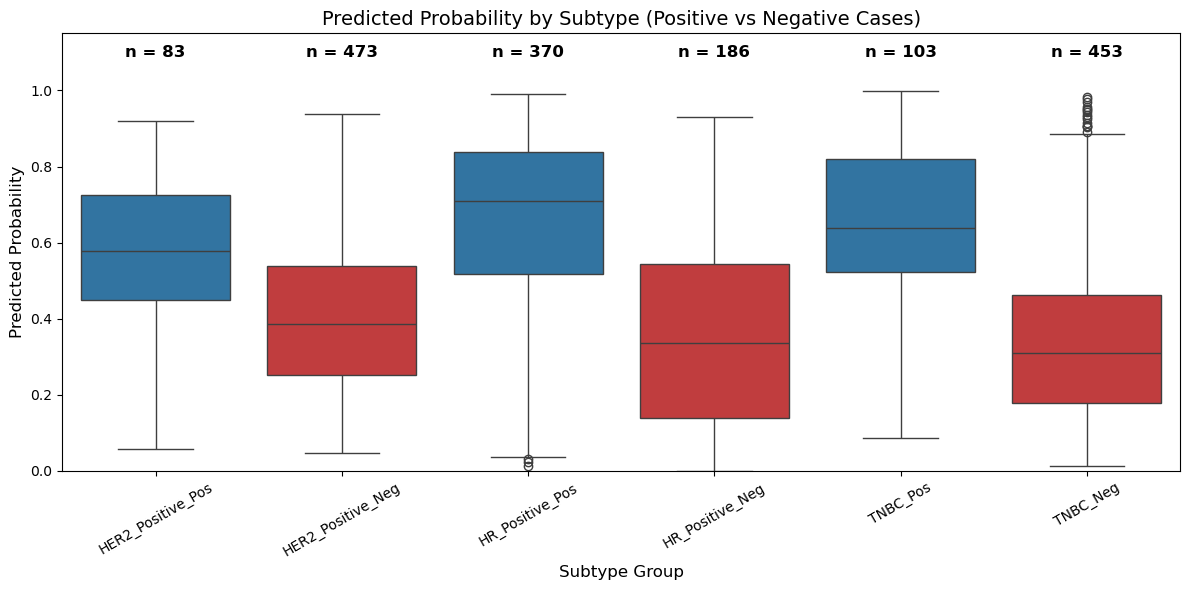

In [15]:
# Prepare positive and negative subsets using true label columns
HER2_pos = combined_results_df[combined_results_df['true_label_HER2_Positive'] == 1]
HER2_neg = combined_results_df[combined_results_df['true_label_HER2_Positive'] == 0]

HR_pos = combined_results_df[combined_results_df['true_label_HR_Positive'] == 1]
HR_neg = combined_results_df[combined_results_df['true_label_HR_Positive'] == 0]

TNBC_pos = combined_results_df[combined_results_df['true_label_TNBC_3'] == 1]
TNBC_neg = combined_results_df[combined_results_df['true_label_TNBC_3'] == 0]

# Construct a DataFrame for boxplot visualization
plot_df = pd.DataFrame({
    'Subtype_Label': ['HER2_Positive_Pos'] * len(HER2_pos) +
                     ['HER2_Positive_Neg'] * len(HER2_neg) +
                     ['HR_Positive_Pos'] * len(HR_pos) +
                     ['HR_Positive_Neg'] * len(HR_neg) +
                     ['TNBC_Pos'] * len(TNBC_pos) +
                     ['TNBC_Neg'] * len(TNBC_neg),
    'Predicted_Probability': pd.concat([
        HER2_pos['predicted_probability_HER2_Positive'],
        HER2_neg['predicted_probability_HER2_Positive'],
        HR_pos['predicted_probability_HR_Positive'],
        HR_neg['predicted_probability_HR_Positive'],
        TNBC_pos['predicted_probability_TNBC_3'],
        TNBC_neg['predicted_probability_TNBC_3']
    ], axis=0)
})

# Define color palette for positive/negative cases
palette = {
    'HER2_Positive_Pos': '#1f77b4',
    'HER2_Positive_Neg': '#d62728',
    'HR_Positive_Pos': '#1f77b4',
    'HR_Positive_Neg': '#d62728',
    'TNBC_Pos': '#1f77b4',
    'TNBC_Neg': '#d62728'
}

# Create the boxplot
plt.figure(figsize=(12, 6))
ax = sns.boxplot(
    data=plot_df,
    x='Subtype_Label',
    y='Predicted_Probability',
    hue='Subtype_Label',
    palette=palette,
    legend=False
)

# Annotate sample sizes above each box
group_counts = plot_df['Subtype_Label'].value_counts()
for tick, label in enumerate(ax.get_xticklabels()):
    subtype = label.get_text()
    count = group_counts[subtype]
    ax.text(tick, 1.08, f'n = {count}', ha='center', va='bottom',
            fontsize=12, fontweight='bold', color='black')

# Final formatting
ax.set_ylim(0, 1.15)
plt.title("Predicted Probability by Subtype (Positive vs Negative Cases)", fontsize=14)
plt.xlabel("Subtype Group", fontsize=12)
plt.ylabel("Predicted Probability", fontsize=12)
plt.xticks(rotation=30, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


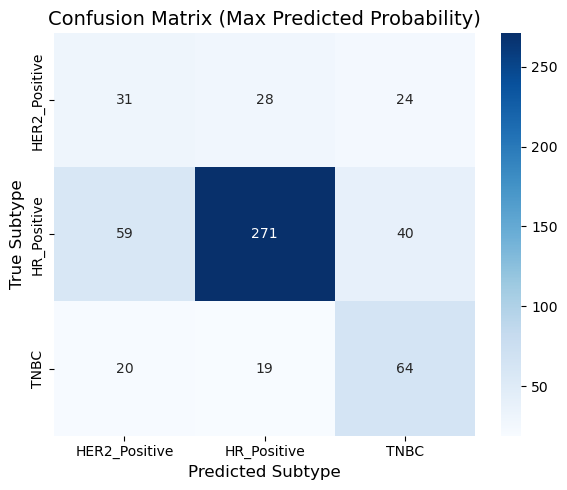

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define subtype labels
subtypes = ['HER2_Positive', 'HR_Positive', 'TNBC']

# Step 1: Define true labels using true_label_<subtype> columns
def get_true_subtype(row):
    if row['true_label_HER2_Positive'] == 1:
        return 'HER2_Positive'
    elif row['true_label_HR_Positive'] == 1:
        return 'HR_Positive'
    elif row['true_label_TNBC_3'] == 1:
        return 'TNBC'
    else:
        return 'Unknown'

# Step 2: Assign predicted subtype using max of predicted probabilities
def get_predicted_subtype(row):
    probs = {
        'HER2_Positive': row['predicted_probability_HER2_Positive'],
        'HR_Positive': row['predicted_probability_HR_Positive'],
        'TNBC': row['predicted_probability_TNBC_3']
    }
    return max(probs, key=probs.get)

# Apply true and predicted subtype logic
combined_results_df['true_subtype'] = combined_results_df.apply(get_true_subtype, axis=1)
combined_results_df['predicted_subtype'] = combined_results_df.apply(get_predicted_subtype, axis=1)

# Step 3: Filter valid rows (exclude ambiguous/unknown cases)
valid_df = combined_results_df[combined_results_df['true_subtype'] != 'Unknown']

# Step 4: Compute confusion matrix
cm = confusion_matrix(valid_df['true_subtype'], valid_df['predicted_subtype'], labels=subtypes)

# Step 5: Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=subtypes, yticklabels=subtypes)
plt.xlabel("Predicted Subtype", fontsize=12)
plt.ylabel("True Subtype", fontsize=12)
plt.title("Confusion Matrix (Max Predicted Probability)", fontsize=14)
plt.tight_layout()
plt.show()


In [17]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Define subtype order
subtypes = ['HER2_Positive', 'HR_Positive', 'TNBC']

# Step 1: Extract true and predicted labels
y_true = valid_df['true_subtype']
y_pred = valid_df['predicted_subtype']

# Step 2: Compute overall accuracy
overall_accuracy = accuracy_score(y_true, y_pred)
print(f"\nOverall Accuracy: {overall_accuracy:.4f}")

# Step 3: Generate classification report for defined subtypes
report = classification_report(y_true, y_pred, labels=subtypes, output_dict=True)

# Step 4: Compute per-class metrics using confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=subtypes)
balanced_accuracies = []
specificities = []
recalls = []

for i, label in enumerate(subtypes):
    TP = cm[i, i]
    FN = cm[i, :].sum() - TP
    FP = cm[:, i].sum() - TP
    TN = cm.sum() - (TP + FN + FP)

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0  # same as recall
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    balanced_accuracy = (sensitivity + specificity) / 2

    recalls.append(round(sensitivity, 4))
    specificities.append(round(specificity, 4))
    balanced_accuracies.append(round(balanced_accuracy, 4))

# Step 5: Create metrics dataframe in required column order
metrics_df = pd.DataFrame({
    'balanced_accuracy': balanced_accuracies,
    'sensitivity (recall)': recalls,
    'specificity': specificities,
    'precision': [report[label]['precision'] for label in subtypes],
    'f1-score': [report[label]['f1-score'] for label in subtypes],
    'support': [report[label]['support'] for label in subtypes],
}, index=subtypes)

# Step 6: Round for display
metrics_df = metrics_df.round(4)

# Step 7: Compute and print mean balanced accuracy
mean_balanced_accuracy = round(sum(balanced_accuracies) / len(balanced_accuracies), 4)
print(f"\nMean Balanced Accuracy: {mean_balanced_accuracy:.4f}")

# Step 8: Print final metrics
print("\nPer-Class Performance Metrics:")
metrics_df



Overall Accuracy: 0.6583

Mean Balanced Accuracy: 0.6944

Per-Class Performance Metrics:


,balanced_accuracy,sensitivity (recall),specificity,precision,f1-score,support
HER2_Positive,0.6032,0.3735,0.8330,0.2818,0.3212,83.0
HR_Positive,0.7399,0.7324,0.7473,0.8522,0.7878,370.0
TNBC,0.7400,0.6214,0.8587,0.5000,0.5541,103.0
